In [1]:
import numpy as np 
import pandas as pd 
pd.options.mode.chained_assignment = None
from matplotlib import pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LeakyReLU, Dropout, LSTM, Dense
from tensorflow.keras.optimizers import Adam, Adagrad
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
from keras_tuner import RandomSearch
import tensorflow
tensorflow.keras.backend.set_epsilon(1)
import seaborn as sns
sns.set()

In [2]:
def switch_positions_for_columns(df):
    columns = ['is_price_diff_more_than_0_49', 'is_price_will_go_up', 'trade_price', 'price_diff_interval']
    for i in range(0, len(columns)):
        column = columns[i]
        first_col = df.pop(column)
        df.insert(0, column, first_col)
    return df
def switch_positions_for_columns_for_trades(df):
    columns = ['trade_price', 'trade_qty', 'trade_quoteQty']
    for i in range(0, len(columns)):
        column = columns[i]
        first_col = df.pop(column)
        df.insert(0, column, first_col)
    return df

In [5]:
df = pd.read_csv('finished_datasets/finished_dataset_with_trades_price_2_min.csv')
df = df.astype('float32')
df[['time']] = df[['time']].astype('int32')
df.drop(df.loc[df['is_price_diff_more_than_0_49'] == 10000].index, inplace=True)

In [6]:
df

,time,bid_0,bid_1,bid_2,bid_3,bid_4,bid_5,bid_6,bid_7,bid_8,...,askQTY_44,askQTY_45,askQTY_46,askQTY_47,askQTY_48,askQTY_49,trade_price,is_price_will_go_up,is_price_diff_more_than_0_49,price_diff_interval
0,1627253504,2157.0,2157.0,2157.0,2157.0,2157.0,2157.0,2157.0,2157.0,2157.0,...,0.0,48.0,69.0,0.0,2.0,10.0,2157.0,0.0,0.0,0.046361
1,1627253504,2157.0,2157.0,2157.0,2157.0,2157.0,2157.0,2157.0,2157.0,2157.0,...,0.0,9.0,0.0,1.0,0.0,5.0,2157.0,0.0,0.0,0.046361
2,1627253504,2157.0,2157.0,2157.0,2157.0,2157.0,2157.0,2157.0,2157.0,2157.0,...,1.0,7.0,64.0,9.0,69.0,2.0,2157.0,0.0,0.0,0.000000
3,1627253504,2157.0,2157.0,2157.0,2157.0,2157.0,2157.0,2157.0,2157.0,2157.0,...,2.0,1.0,0.0,18.0,2.0,9.0,2157.0,0.0,0.0,0.000000
4,1627253504,2157.0,2157.0,2157.0,2157.0,2157.0,2157.0,2157.0,2157.0,2157.0,...,2.0,0.0,1.0,41.0,0.0,0.0,2157.0,0.0,0.0,0.046361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135965,1628808832,2992.0,2992.0,2992.0,2992.0,2992.0,2992.0,2992.0,2992.0,2992.0,...,4.0,2.0,1.0,0.0,21.0,3.0,2992.0,0.0,0.0,0.066845
135966,1628808832,2993.0,2993.0,2993.0,2993.0,2993.0,2993.0,2993.0,2993.0,2993.0,...,1.0,2.0,1.0,1.0,114.0,0.0,2994.0,0.0,0.0,0.133601
135967,1628808832,2993.0,2993.0,2992.0,2992.0,2992.0,2992.0,2992.0,2992.0,2992.0,...,1.0,2.0,2.0,5.0,0.0,4.0,2992.0,0.0,0.0,0.066845
135968,1628808832,2994.0,2994.0,2994.0,2994.0,2994.0,2994.0,2994.0,2994.0,2993.0,...,3.0,3.0,1.0,2.0,9.0,1.0,2994.0,0.0,0.0,0.167001


In [18]:
df = switch_positions_for_columns(df)

In [19]:
need_columns = ['is_price_diff_more_than_0_49', 'is_price_will_go_up', 'trade_price', 'price_diff_interval']
need_df = df[need_columns]

In [21]:
countDiff = 0
for i in range(0, len(df)):
    diff = df.values[i][0]
    if diff >= 0.1:
        countDiff = countDiff + 1
print(countDiff)
print(round(countDiff/len(df), 3) * 100)

98288
72.3


In [6]:
def getParams(df, window, firstIndex, lastIndex):
    params = []
    df = np.array(df)
    for t in range(window, len(df)):
        pastParams = df[t - window:t, firstIndex:lastIndex]
        params.append(pastParams)
    return params

def getDfColumns(params, columnKey):
    columns = []
    for i in range(0, len(params[0])):
        for t in range(0, len(params[0][0])):
                columns.append(columnKey + str(i) + '_' +  str(t))
    return columns

def fillDf(df, params, columnKey):
    for i in range(0, len(params)):
        for t in range(0, len(params[i])):
            for m in range(0, len(params[i][t])):
                df.loc[columnKey + str(i) + '_' +  str(t)] =  params[i][t][m]
    return df

In [7]:
df

,price_diff_interval,trade_price,is_price_will_go_up,is_price_diff_more_than_0_49,time,bid_0,bid_1,bid_2,bid_3,bid_4,...,askQTY_40,askQTY_41,askQTY_42,askQTY_43,askQTY_44,askQTY_45,askQTY_46,askQTY_47,askQTY_48,askQTY_49
0,0.092721,2157.0,1.0,0.0,1.627254e+09,2157.0,2157.0,2157.0,2157.0,2157.0,...,5.0,1.0,0.0,23.0,0.0,48.0,69.0,0.0,2.0,10.0
1,0.092721,2157.0,1.0,0.0,1.627254e+09,2157.0,2157.0,2157.0,2157.0,2157.0,...,0.0,0.0,0.0,42.0,0.0,9.0,0.0,1.0,0.0,5.0
2,0.139082,2157.0,1.0,0.0,1.627254e+09,2157.0,2157.0,2157.0,2157.0,2157.0,...,0.0,4.0,0.0,2.0,1.0,7.0,64.0,9.0,69.0,2.0
3,0.092721,2157.0,1.0,0.0,1.627254e+09,2157.0,2157.0,2157.0,2157.0,2157.0,...,1.0,0.0,4.0,0.0,2.0,1.0,0.0,18.0,2.0,9.0
4,0.092721,2157.0,1.0,0.0,1.627254e+09,2157.0,2157.0,2157.0,2157.0,2157.0,...,30.0,25.0,5.0,0.0,2.0,0.0,1.0,41.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135921,0.133556,2995.0,0.0,0.0,1.628809e+09,2995.0,2995.0,2995.0,2995.0,2995.0,...,0.0,0.0,1.0,3.0,1.0,5.0,1.0,1.0,12.0,0.0
135922,0.166945,2995.0,0.0,0.0,1.628809e+09,2995.0,2995.0,2995.0,2995.0,2995.0,...,0.0,7.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,2.0
135923,0.166945,2995.0,0.0,0.0,1.628809e+09,2995.0,2995.0,2995.0,2995.0,2995.0,...,0.0,1.0,2.0,2.0,2.0,0.0,1.0,0.0,0.0,1.0
135924,0.200334,2995.0,0.0,0.0,1.628809e+09,2995.0,2995.0,2995.0,2995.0,2995.0,...,3.0,4.0,2.0,1.0,1.0,0.0,2.0,0.0,1.0,5.0


In [7]:
%%time
window = 120
skip = 49
bids = getParams(df, window, 4 + skip, 54)
qtyBids = getParams(df, window, 54 + skip, 104)
asks = getParams(df, window, 104 + skip, 154)
qtyAsks = getParams(df, window, 154 + skip, 204)

Wall time: 231 ms


In [8]:
%%time
bidsColumns = getDfColumns(bids, 'bid_')
qtyBidsColumns = getDfColumns(qtyBids, 'qtyBid_')
asksColumns = getDfColumns(asks, 'ask_')
qtyAsksColumns = getDfColumns(qtyAsks, 'qtyAsk_')

Wall time: 1 ms


In [9]:
%%time
bidsDf = pd.DataFrame(columns = bidsColumns, data = np.array(bids).reshape(len(bids), window * (50 - skip)))
qtyBidsDf = pd.DataFrame(columns = qtyBidsColumns, data = np.array(qtyBids).reshape(len(qtyBids), window * (50 - skip)))
asksDf = pd.DataFrame(columns = asksColumns, data = np.array(asks).reshape(len(asks), window * (50 - skip)))
qtyAsksDf = pd.DataFrame(columns = qtyAsksColumns, data = np.array(qtyAsks).reshape(len(qtyAsks), window * (50 - skip)))
frames = [need_df, bidsDf, qtyBidsDf, asksDf, qtyAsksDf]
finish_df = pd.concat(frames, axis = 1)

Wall time: 393 ms


In [10]:
finish_df = finish_df.dropna()

In [11]:
df_window = 5000
df_train = finish_df.iloc[0:100_000]
df_test = finish_df.iloc[100_000:135_000]

In [12]:
Y = df_train[['is_price_will_go_up']]
Y_final_test = df_test[['is_price_will_go_up']]

df_test = df_test.drop(need_columns, axis = 1)
df_train = df_train.drop(need_columns, axis = 1)

In [13]:
X = df_train
X_final_test = df_test

In [14]:
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler_Y = preprocessing.MinMaxScaler()

# nsamples, nx, ny = X.shape
# X = X.reshape((nsamples,nx * ny))

# nsamples, nx, ny = X_final_test.shape
# X_final_test = X_final_test.reshape((nsamples,nx * ny))

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.4)

min_max_scaler = min_max_scaler.fit(X_train)
X_train = min_max_scaler.transform(X_train)
X_val = min_max_scaler.transform(X_val)
X_final_test = min_max_scaler.transform(X_final_test)

# min_max_scaler_Y = min_max_scaler_Y.fit(Y_train)
# Y_train = min_max_scaler_Y.fit_transform(Y_train)
# Y_val = min_max_scaler_Y.fit_transform(Y_val)
# Y_final_test = min_max_scaler_Y.fit_transform(Y_final_test)

# X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
# X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)
# X_final_test = X_final_test.reshape(X_final_test.shape[0],X_final_test.shape[1] , 1)

# Y_train = Y_train.reshape(Y_train.shape[0],Y_train.shape[1] , 1)
# Y_val = Y_val.reshape(Y_val.shape[0],Y_val.shape[1] , 1)
# Y_final_test = Y_final_test.reshape(Y_final_test.shape[0],Y_final_test.shape[1] , 1)


In [15]:
X_train.shape

(60000, 480)

Epoch 1/200
235/235 [==============================] - 1s 2ms/step - loss: 0.6898 - acc: 0.5432 - val_loss: 0.6873 - val_acc: 0.5523
Epoch 2/200
235/235 [==============================] - 0s 2ms/step - loss: 0.6858 - acc: 0.5575 - val_loss: 0.6763 - val_acc: 0.5714
Epoch 3/200
235/235 [==============================] - 0s 2ms/step - loss: 0.6723 - acc: 0.5920 - val_loss: 0.6530 - val_acc: 0.5976
Epoch 4/200
235/235 [==============================] - 0s 2ms/step - loss: 0.6706 - acc: 0.6038 - val_loss: 0.6805 - val_acc: 0.5793
Epoch 5/200
235/235 [==============================] - 0s 2ms/step - loss: 0.6681 - acc: 0.5983 - val_loss: 0.6687 - val_acc: 0.5882
Epoch 6/200
235/235 [==============================] - 0s 2ms/step - loss: 0.6593 - acc: 0.6252 - val_loss: 0.6257 - val_acc: 0.6615
Epoch 7/200
235/235 [==============================] - 0s 2ms/step - loss: 0.6723 - acc: 0.5876 - val_loss: 0.6894 - val_acc: 0.5453
Epoch 8/200
235/235 [==============================] - 0s 2ms/step - 

235/235 [==============================] - 0s 2ms/step - loss: 0.3226 - acc: 0.8568 - val_loss: 0.3064 - val_acc: 0.8626
Epoch 124/200
235/235 [==============================] - 0s 2ms/step - loss: 0.3228 - acc: 0.8566 - val_loss: 0.3697 - val_acc: 0.8249
Epoch 125/200
235/235 [==============================] - 0s 2ms/step - loss: 0.3240 - acc: 0.8554 - val_loss: 0.3100 - val_acc: 0.8648
Epoch 126/200
235/235 [==============================] - 0s 2ms/step - loss: 0.3156 - acc: 0.8584 - val_loss: 0.3016 - val_acc: 0.8674
Epoch 127/200
235/235 [==============================] - 0s 2ms/step - loss: 0.3075 - acc: 0.8641 - val_loss: 0.2870 - val_acc: 0.8783
Epoch 128/200
235/235 [==============================] - 0s 2ms/step - loss: 0.3179 - acc: 0.8586 - val_loss: 0.2897 - val_acc: 0.8771
Epoch 129/200
235/235 [==============================] - 0s 2ms/step - loss: 0.3481 - acc: 0.8443 - val_loss: 0.3251 - val_acc: 0.8461
Epoch 130/200
235/235 [==============================] - 0s 2ms/step 

Epoch 184/200
235/235 [==============================] - 0s 2ms/step - loss: 0.2825 - acc: 0.8746 - val_loss: 0.3497 - val_acc: 0.8366
Epoch 185/200
235/235 [==============================] - 0s 2ms/step - loss: 0.3178 - acc: 0.8531 - val_loss: 0.2854 - val_acc: 0.8882
Epoch 186/200
235/235 [==============================] - 0s 2ms/step - loss: 0.2903 - acc: 0.8704 - val_loss: 0.2912 - val_acc: 0.8789
Epoch 187/200
235/235 [==============================] - 0s 2ms/step - loss: 0.2888 - acc: 0.8724 - val_loss: 0.5423 - val_acc: 0.7672
Epoch 188/200
235/235 [==============================] - 0s 2ms/step - loss: 0.3088 - acc: 0.8604 - val_loss: 0.3048 - val_acc: 0.8598
Epoch 189/200
235/235 [==============================] - 0s 2ms/step - loss: 0.3086 - acc: 0.8584 - val_loss: 0.3126 - val_acc: 0.8561
Epoch 190/200
235/235 [==============================] - 0s 2ms/step - loss: 0.2813 - acc: 0.8755 - val_loss: 0.3082 - val_acc: 0.8611
Epoch 191/200
235/235 [==============================] 

<AxesSubplot:>

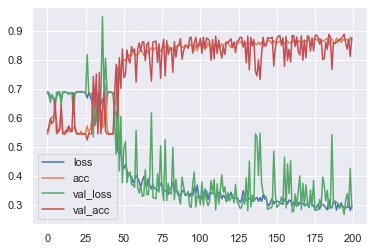

In [16]:
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow import keras

layer_koeff = 1

actv = 'tanh'

units = [60, 40, 30, 20, 10, 8, 6, 128]

#     model.add(Dense(unit * layer_koeff, 
#         activation = actv, 
#         kernel_regularizer=regularizers.l1_l2(l1=1e-7, l2=1e-7)
#     ))

model = Sequential()

for i in range(0, len(units)):
    unit = units[i]
    model.add(Dense(unit * layer_koeff, 
        activation = actv,
        kernel_regularizer=regularizers.l1_l2(l1=1e-7, l2=1e-7)
    ))
    #model.add(Dropout(0.5))
    
model.add(Dense(1, activation = 'sigmoid'))

# compile the model, adam gradient descent (optimized)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
es = EarlyStopping(monitor='val_acc', min_delta=0.0, patience=75, verbose=1, mode='max', restore_best_weights=True)
history = model.fit(X_train, Y_train, epochs = 200, batch_size=256, validation_data=(X_val, Y_val), verbose=1, callbacks = [es])

losses = pd.DataFrame(model.history.history)
losses.plot()

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 60)                28860     
_________________________________________________________________
dense_1 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1230      
_________________________________________________________________
dense_3 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 88        
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 5

In [18]:
es.best

0.888949990272522

In [19]:
pred = model.predict(X_final_test)

In [20]:
pred_df = pd.DataFrame(pred)

In [21]:
X_final_test.shape

(35000, 480)

In [22]:
pred_df

,0
0,0.373868
1,0.251132
2,0.217355
3,0.192095
4,0.127978
...,...
34995,0.002169
34996,0.002800
34997,0.003099
34998,0.004429


In [23]:
pred_df[[0]].mean()

0    0.491336
dtype: float32

In [24]:
Y_final_test[['is_price_will_go_up']].mean()

is_price_will_go_up    0.440171
dtype: float32

In [25]:
Y_final_test

,is_price_will_go_up
100000,0.0
100001,0.0
100002,0.0
100003,0.0
100004,0.0
...,...
134995,0.0
134996,0.0
134997,0.0
134998,0.0


In [26]:
score, acc = model.evaluate(X_final_test, Y_final_test,
                            batch_size=64)
print('Test score:', score)
print('Test accuracy:', acc)

547/547 [==============================] - 0s 510us/step - loss: 0.3160 - acc: 0.8701
Test score: 0.31602686643600464
Test accuracy: 0.8701428771018982


In [27]:
model.save(f'E:/Programs/OpenServer/domains/trade-py/models/price_direction_2min/model/nn.h5', include_optimizer = False)

In [28]:
#import pickle

scaler_X = 'E:/Programs/OpenServer/domains/trade-py/models/price_direction_2min/scaler_X.sav'

In [29]:
import joblib
joblib.dump(min_max_scaler, scaler_X) 

['E:/Programs/OpenServer/domains/trade-py/models/price_direction_2min/scaler_X.sav']

In [107]:
X_val.shape

(4000, 1200)

In [109]:
X_train.shape

(36000, 1200)

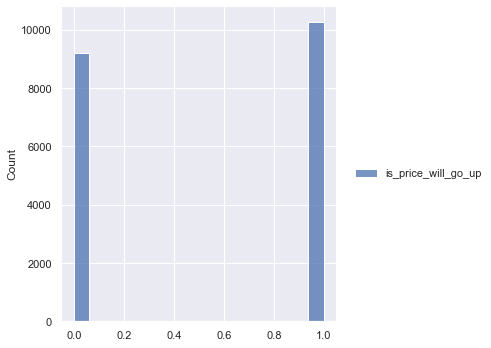

In [45]:
sns.displot(Y_final_test)

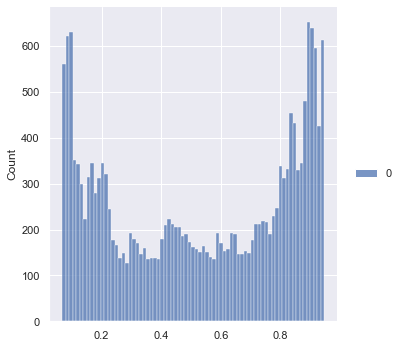

In [47]:
sns.displot(pred, bins = 75)

In [48]:
# Regression chart.
def chart_regression(pred, y, sort=True):
    t = pd.DataFrame({'pred': pred, 'y': y.flatten()})
    if sort:
        t.sort_values(by=['y'], inplace=True)
    plt.plot(t['y'].tolist(), label='expected')
    plt.plot(t['pred'].tolist(), label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

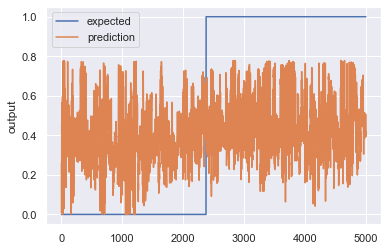

In [77]:
# Plot the chart
chart_regression(pred_df.values.flatten(),Y_final_test.values)

In [70]:
from sklearn import metrics
import numpy as np
import pandas as pd

def inf(y_true, y_pred, window = 0.05):
    assert len(y_true) == len(y_pred), 'y_true != y_pred'

    # if we have binary classifiction with 2-neurons and softmax
    try:
        y_true, y_pred = y_true[:, 1], y_pred[:, 1]
    except:
        y_true, y_pred = y_true[:, 0], y_pred[:, 0]


    def accuracy(y_true, y_pred):
        return 1 - np.abs(np.round(y_pred) - y_true).sum()/len(y_true)


    def delta_probability_mean_score(y_true, y_pred, d1, d2):
        """ Calculate probability_mean_score in window from d1 to d2
        for example:
            d1 = 0.
            d2 = 0.5
        this will calculate probability_mean_score from this window (probability_mean_score for 0 label)
        """
        if d2 < d1:
            d2, d1 = d1, d2
        arr = y_true[(y_pred >= d1) & (y_pred <= d2)] - y_pred[(y_pred >= d1) & (y_pred <= d2)]
        return abs((arr.sum()/len(arr))*100)


    def delta_accuracy(y_true, y_pred, d1, d2):    
        if d2 < d1:
            d2, d1 = d1, d2
        y_true, y_pred = y_true[(y_pred >= d1) & (y_pred <= d2)], y_pred[(y_pred >= d1) & (y_pred <= d2)]

        if len(y_pred) == 0:
            return None, None
        else:
            return accuracy(y_true, y_pred), len(y_pred)


    pred_len = len(y_pred)
    print('Balance Y :', round(np.array(y_true).sum()/len(y_true), 3))
    print('Accuracy  :', round(accuracy(y_true, y_pred), 3))
    print('Precision :', round(metrics.precision_score(y_true, np.around(y_pred)), 3))
    print('Recall    :', round(metrics.recall_score(y_true, np.around(y_pred)), 3))
    print('MSE       :', round(metrics.mean_squared_error(y_true, y_pred), 3)) # brier score
    print()
    print('Confusion matrix')
    print(metrics.confusion_matrix(y_true, np.around(y_pred)))
    print()

    best_model = pd.DataFrame()
    delta = np.arange(0., 1.0, window)
    # we will collect abs score in this list, then we calculate average score 
    abs_score_list = []

    for d in delta:
        acc, games = delta_accuracy(y_true, y_pred, d, d + window)
        if games != None:
            score = round(delta_probability_mean_score(y_true, y_pred, d, d + window), 1)

            if d < 0.5:
                column = f"{int(100 - round(d, 2)*100)}% - {int(100 - round(d+window, 2)*100)} %"
            else:
                column = f"{int(round(d, 2)*100)}% - {int(round(d+window, 2)*100)} %"

            best_model.loc['Accuracy ____________________', column] = str(round(acc*100, 2)) + ' %'
            best_model.loc['Score', column] = str(round(score, 3))
            best_model.loc['Games%', column] = str(int(games*100/pred_len)) 
            best_model.loc['Games', column] = str(games)


            abs_score_list.append(abs(score))

    print(f"Abs probability_mean_score per windows: {round(np.array(abs_score_list).mean(), 3)}")
    print('Number of predictions :', pred_len)
    print()
    
    return best_model

In [74]:
best_model = inf(Y_val.values, pred_dataset.values)

Balance Y : 0.519
Accuracy  : 0.805
Precision : 0.927
Recall    : 0.678
MSE       : 0.152

Confusion matrix
[[4106  251]
 [1513 3184]]

Abs probability_mean_score per windows: 18.675
Number of predictions : 9054



In [79]:
best_model

,100% - 95 %,95% - 90 %,90% - 85 %,85% - 80 %,80% - 75 %,75% - 70 %,70% - 65 %,65% - 60 %,60% - 55 %,55% - 50 %,50% - 55 %,55% - 60 %,60% - 65 %,65% - 70 %,70% - 75 %,75% - 80 %,80% - 85 %,85% - 90 %,90% - 95 %,95% - 100 %
Accuracy ____________________,100.0 %,99.53 %,98.38 %,97.28 %,96.28 %,94.72 %,86.97 %,64.58 %,45.07 %,24.23 %,87.1 %,89.9 %,90.55 %,96.71 %,96.72 %,99.2 %,99.61 %,98.81 %,100.0 %,71.64 %
Score,2.9,7.1,11.1,14.9,18.8,22.4,19.6,2.1,12.5,28.3,34.5,32.6,28.1,29.2,24.5,21.9,17.0,11.6,7.8,26.6
Games%,1,2,3,4,5,7,8,10,8,8,7,6,5,4,4,2,2,1,0,0
Games,152,214,309,441,511,720,798,926,801,747,713,624,476,425,396,250,258,168,58,67
